<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df = df.resample('1H').sum()

In [4]:
df.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [6]:
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

## Анализ

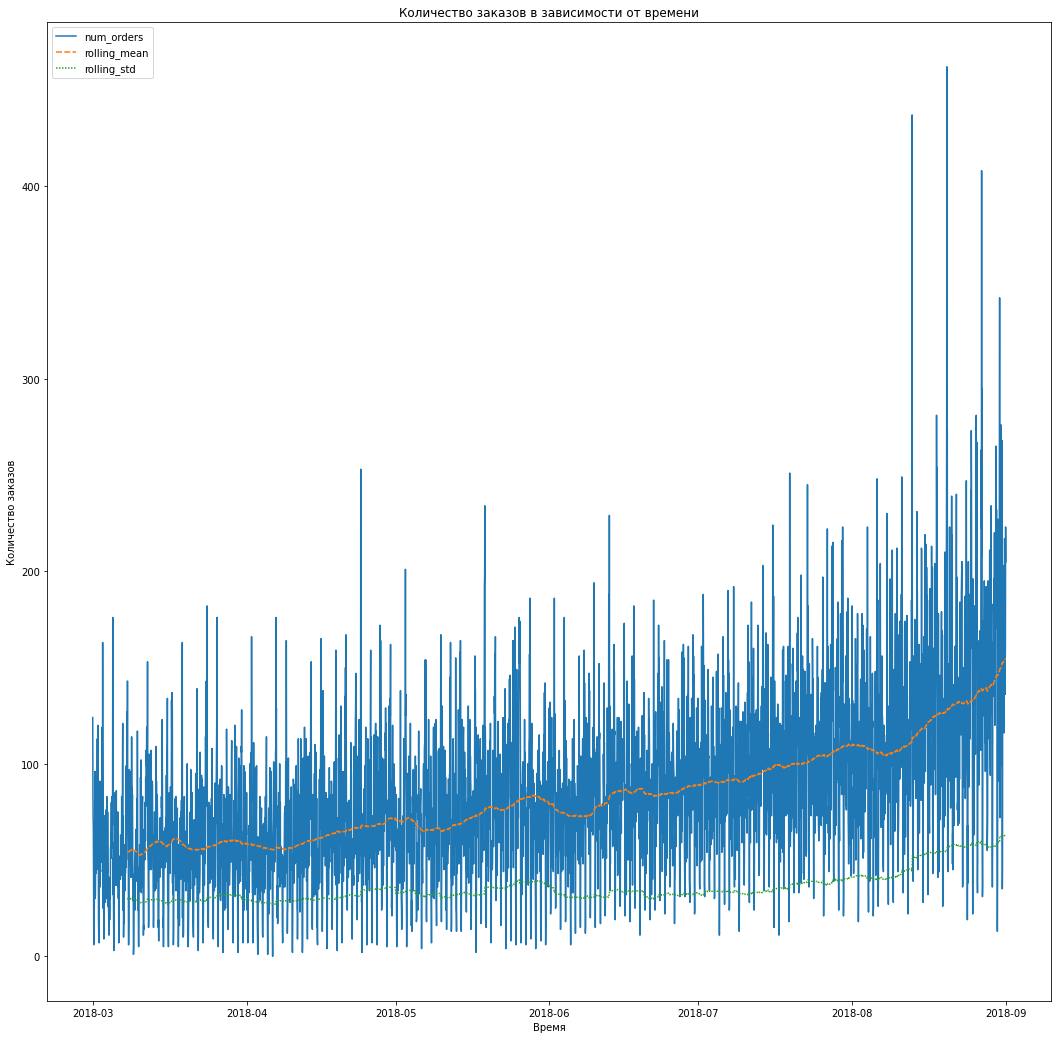

In [7]:
fig, ax = plt.subplots(figsize=(18, 18))
data = df.copy()
data['rolling_mean'] = data['num_orders'].shift().rolling(168).mean() #168 часов - неделя
data['rolling_std'] = data['num_orders'].shift().rolling(168).std() #168 часов - неделя
sns.lineplot(data=data, ax=ax)
ax.set_xlabel("Время")
ax.set_ylabel("Количество заказов")
ax.set_title("Количество заказов в зависимости от времени")
plt.show()

Среднее значение постепенно увеличивается, на свой максимум выходит в сентябре

In [8]:
#Добавим скользящее среднее
decomposed = seasonal_decompose(df) 

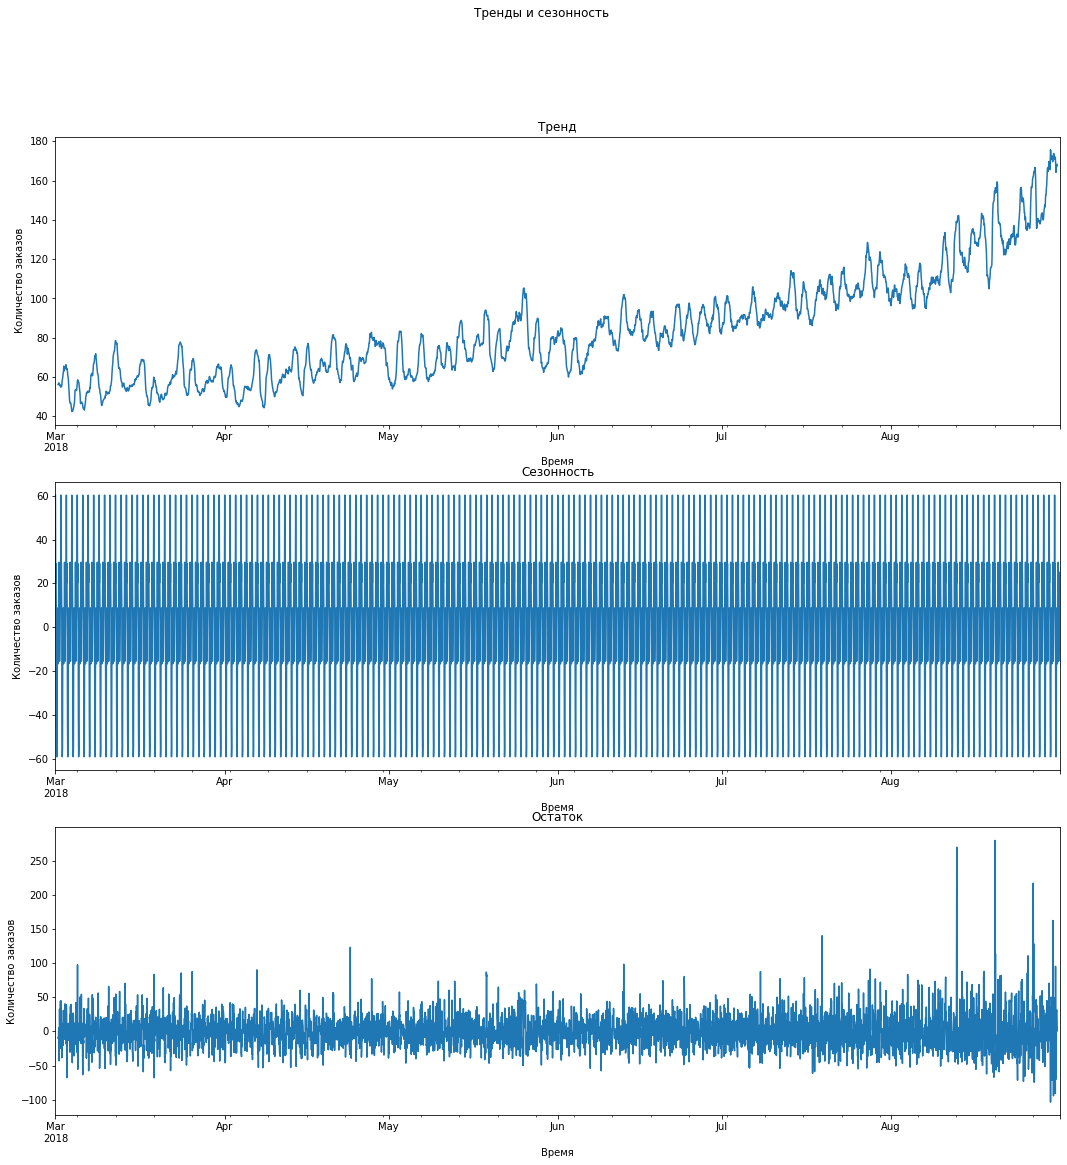

In [9]:
fig, axs = plt.subplots(nrows= 3 , ncols= 1, figsize = (18,18))
decomposed.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

Количество заказов возрастает в течение рассматриваемого периода, выходит на свой пик в сентябре. Период сезонности меньше месяца, возможно это связано с временем суток, возможно со днём недели. Рассмотрим это далее.

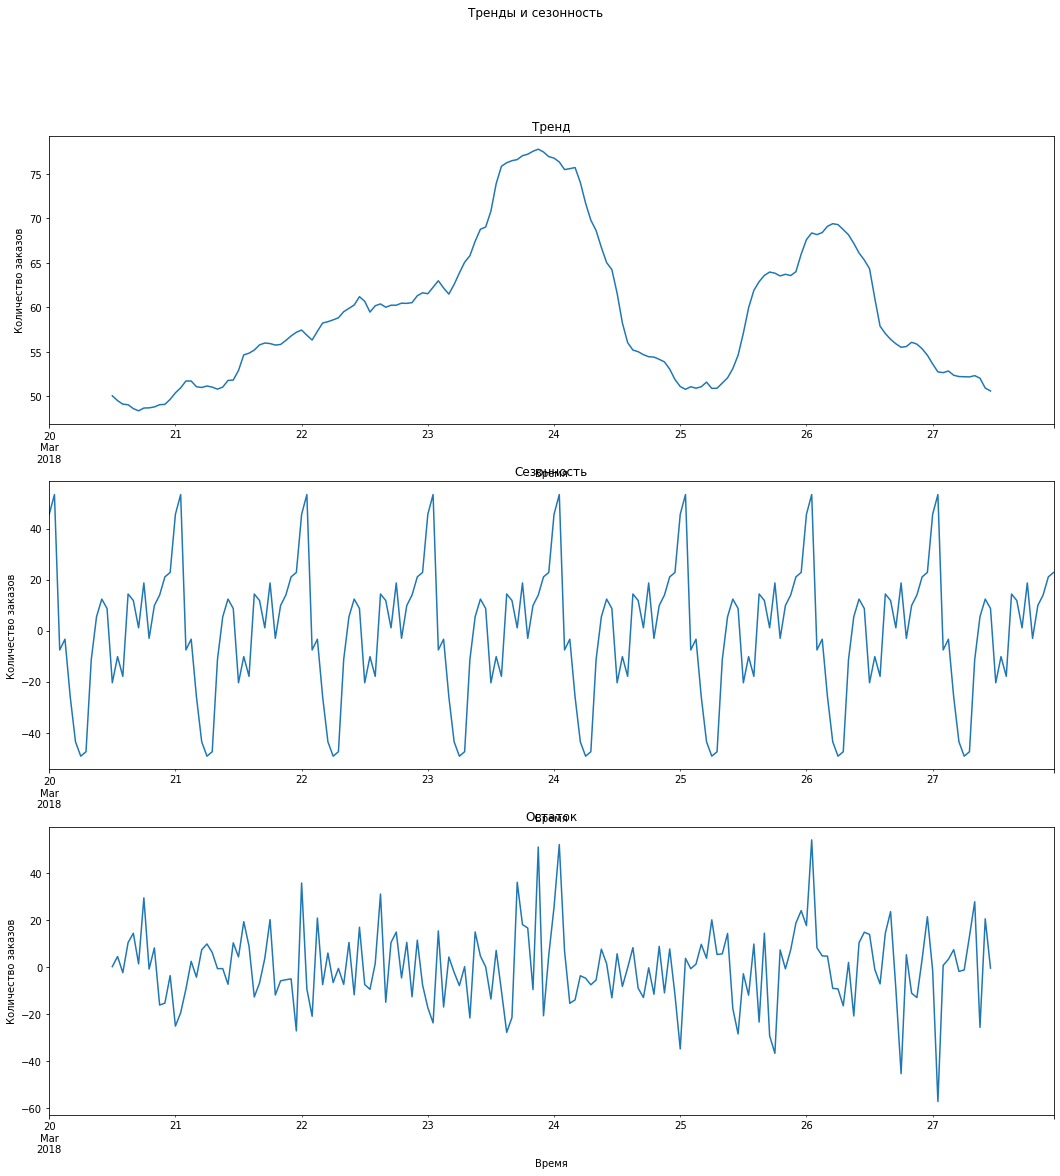

In [10]:
oneday = df['2018-03-20':'2018-03-27']
decomposed = seasonal_decompose(oneday) 
fig, axs = plt.subplots(nrows= 3 , ncols= 1, figsize = (18,18))
decomposed.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

Можно увидеть, что по вечерам - пик нагрузки, ночью - она минимальна,  это и есть сезонность в рамках одного дня

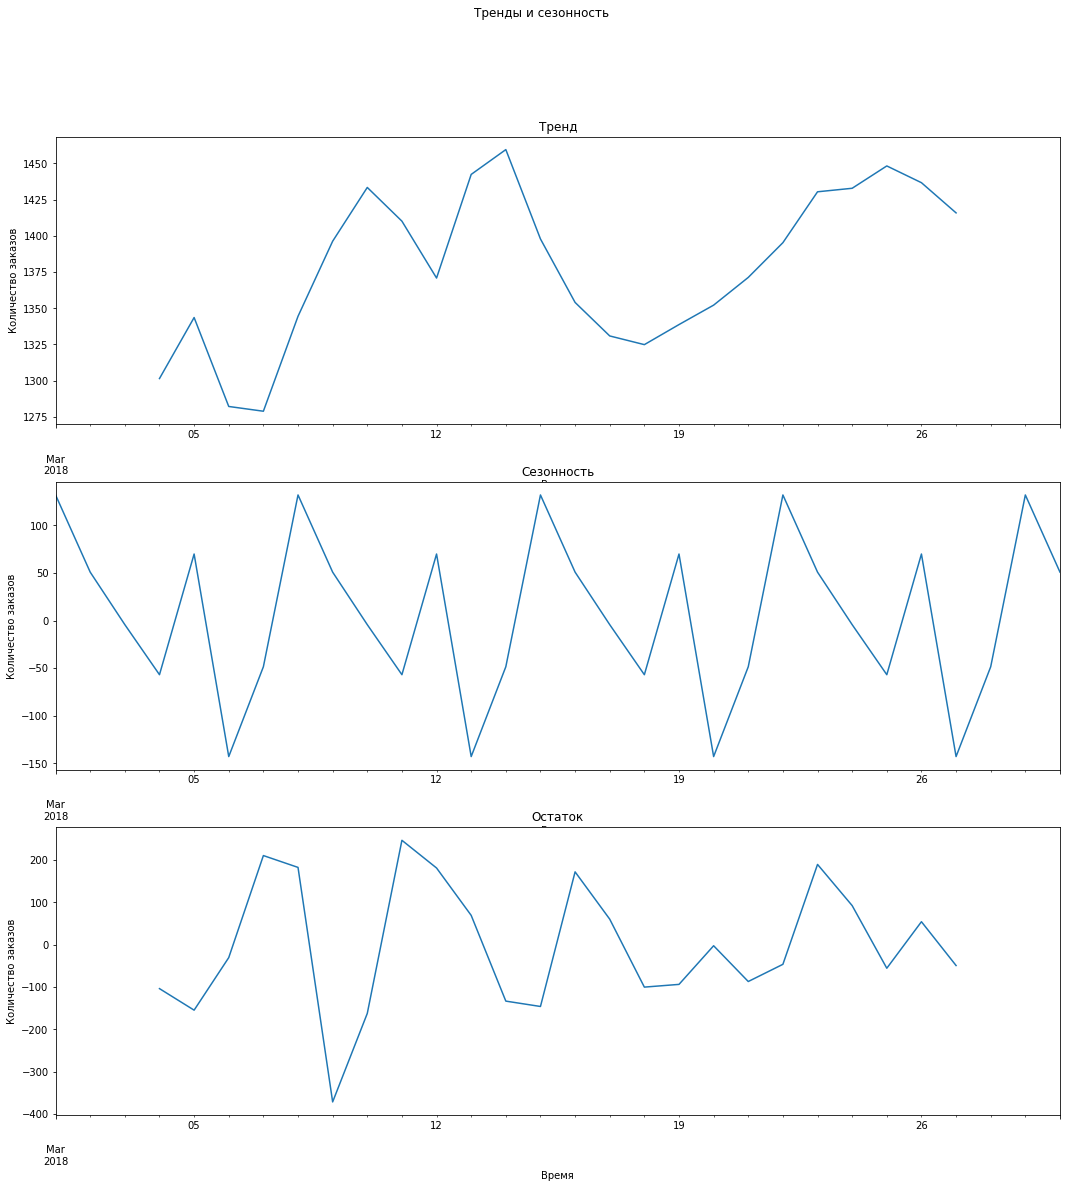

In [11]:
oneweek = df.resample('1D').sum()['2018-03-1':'2018-03-30']
decomposed = seasonal_decompose(oneweek) 
fig, axs = plt.subplots(nrows= 3 , ncols= 1, figsize = (18,18))
decomposed.trend.plot(ax=axs[0])
axs[0].set_xlabel('Время')
axs[0].set_ylabel('Количество заказов')
axs[0].set_title('Тренд')
decomposed.seasonal.plot(ax=axs[1])
axs[1].set_xlabel('Время')
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Сезонность')
decomposed.resid.plot(ax=axs[2])
axs[2].set_xlabel('Время')
axs[2].set_ylabel('Количество заказов')
axs[2].set_title('Остаток')
fig.suptitle('Тренды и сезонность')
plt.show()

1 марта 2018 года был четверг, соответственно в этот день недели нагрузка на пике, в воскресенье-понедельник нагрузка на такси уменьшается. Это была проанализирована сезонность в рамках дня недели

## Обучение

In [12]:
#Для начала создадим новые признаки
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
ndf = make_features(df, 24, 168)

In [14]:
ndf.tail(10)

num_orders  month  day  dayofweek  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-08-31 14:00:00         133      8   31          4  166.0  136.0  167.0   
2018-08-31 15:00:00         116      8   31          4  133.0  166.0  136.0   
2018-08-31 16:00:00         197      8   31          4  116.0  133.0  166.0   
2018-08-31 17:00:00         217      8   31          4  197.0  116.0  133.0   
2018-08-31 18:00:00         207      8   31          4  217.0  197.0  116.0   
2018-08-31 19:00:00         136      8   31          4  207.0  217.0  197.0   
2018-08-31 20:00:00         154      8   31          4  136.0  207.0  217.0   
2018-08-31 21:00:00         159      8   31          4  154.0  136.0  207.0   
2018-08-31 22:00:00         223      8   31          4  159.0  154.0  136.0   
2018-08-31 23:00:00         205      8   31          4  223.0  159.0  154.0   

                     lag_4  lag_5  lag_6  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-08-31 14:00:00  191.0  203.0  182.0  ...   158.0   198.0   142.0    72.0   
2018-08-31 15:00:00  167.0  191.0  203.0  ...   246.0   158.0   198.0   142.0   
2018-08-31 16:00:00  136.0  167.0  191.0  ...   276.0   246.0   158.0   198.0   
2018-08-31 17:00:00  166.0  136.0  167.0  ...   194.0   276.0   246.0   158.0   
2018-08-31 18:00:00  133.0  166.0  136.0  ...   230.0   194.0   276.0   246.0   
2018-08-31 19:00:00  116.0  133.0  166.0  ...    99.0   230.0   194.0   276.0   
2018-08-31 20:00:00  197.0  116.0  133.0  ...   268.0    99.0   230.0   194.0   
2018-08-31 21:00:00  217.0  197.0  116.0  ...    78.0   268.0    99.0   230.0   
2018-08-31 22:00:00  207.0  217.0  197.0  ...    35.0    78.0   268.0    99.0   
2018-08-31 23:00:00  136.0  207.0  217.0  ...    46.0    35.0    78.0   268.0   

                     lag_20  lag_21  lag_22  lag_23  lag_24  rolling_mean  
datetime                                                                   
2018-08-31 14:00:00   177.0   342.0   254.0   156.0    91.0    153.285714  
2018-08-31 15:00:00    72.0   177.0   342.0   254.0   156.0    153.553571  
2018-08-31 16:00:00   142.0    72.0   177.0   342.0   254.0    153.547619  
2018-08-31 17:00:00   198.0   142.0    72.0   177.0   342.0    153.601190  
2018-08-31 18:00:00   158.0   198.0   142.0    72.0   177.0    153.880952  
2018-08-31 19:00:00   246.0   158.0   198.0   142.0    72.0    154.297619  
2018-08-31 20:00:00   276.0   246.0   158.0   198.0   142.0    154.434524  
2018-08-31 21:00:00   194.0   276.0   246.0   158.0   198.0    154.285714  
2018-08-31 22:00:00   230.0   194.0   276.0   246.0   158.0    154.244048  
2018-08-31 23:00:00    99.0   230.0   194.0   276.0   246.0    154.130952  

[10 rows x 29 columns]

In [15]:
train, test = train_test_split(ndf, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
RANDOM_STATE = 42
param_distributions = [
    {
    'models': [LinearRegression()],
    'models__fit_intercept': [True, False],
    'models__normalize': [True, False],
    }
] 

In [17]:
pipe_final= Pipeline([
    ('models', LinearRegression())
])

In [18]:
tscv = TimeSeriesSplit(n_splits=10)

In [19]:
randomized_search = RandomizedSearchCV( #Регрессия
    pipe_final, 
    param_distributions, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(train.drop('num_orders', axis=1), train['num_orders'])

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression(normalize=True)],
                                         'models__fit_intercept': [True, False],
                                         'models__normalize': [True, False]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [20]:
randomized_search.best_score_*(-1) #Значение метрики <48 => в норме

26.651817039808144

In [21]:
param_distributions_2 = [
    {
        'models': [CatBoostRegressor()],
        'models__iterations': range(500, 2000, 500),
        'models__depth': range(2, 10, 2)
    }
] 

In [22]:
pipe_final_2= Pipeline([
    ('models', CatBoostRegressor())
])

In [23]:
randomized_search_2 = RandomizedSearchCV( #CatBoostRegressor
    pipe_final_2, 
    param_distributions_2, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_2.fit(train.drop('num_orders', axis=1), train['num_orders'])

Learning rate set to 0.034622
0:	learn: 28.3890474	total: 62.7ms	remaining: 1m 2s
1:	learn: 27.9624402	total: 72.6ms	remaining: 36.2s
2:	learn: 27.5483198	total: 82.3ms	remaining: 27.3s
3:	learn: 27.2390017	total: 91.8ms	remaining: 22.8s
4:	learn: 26.8537101	total: 101ms	remaining: 20.1s
5:	learn: 26.4984349	total: 110ms	remaining: 18.3s
6:	learn: 26.1835005	total: 120ms	remaining: 17s
7:	learn: 25.8949423	total: 129ms	remaining: 16s
8:	learn: 25.5484287	total: 138ms	remaining: 15.2s
9:	learn: 25.2590475	total: 147ms	remaining: 14.6s
10:	learn: 24.9413539	total: 156ms	remaining: 14s
11:	learn: 24.6665834	total: 166ms	remaining: 13.6s
12:	learn: 24.4054579	total: 175ms	remaining: 13.3s
13:	learn: 24.1412332	total: 185ms	remaining: 13s
14:	learn: 23.8537993	total: 193ms	remaining: 12.7s
15:	learn: 23.5509238	total: 203ms	remaining: 12.5s
16:	learn: 23.2550586	total: 212ms	remaining: 12.3s
17:	learn: 23.0120597	total: 221ms	remaining: 12.1s
18:	learn: 22.7517250	total: 230ms	remaining: 11

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=Pipeline(steps=[('models',
                                              <catboost.core.CatBoostRegressor object at 0x7f22e4081670>)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x7f22e409e7f0>],
                                         'models__depth': range(2, 10, 2),
                                         'models__iterations': range(500, 2000, 500)}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [24]:
randomized_search_2.best_score_*-1  #Значение метрики <48 => в норме

23.87325964436115

Наилучшее значение метрики у модели с бустингом

## Тестирование

In [25]:
predict_cat = randomized_search_2.predict(test.drop('num_orders', axis=1))
mean_squared_error(test['num_orders'], predict_cat, squared=False)

40.83246970328199

Значения метрики в норме, меньше 48.

In [26]:
predict = pd.DataFrame(predict_cat)
predict['data'] = test.index
predict = predict.set_index('data')

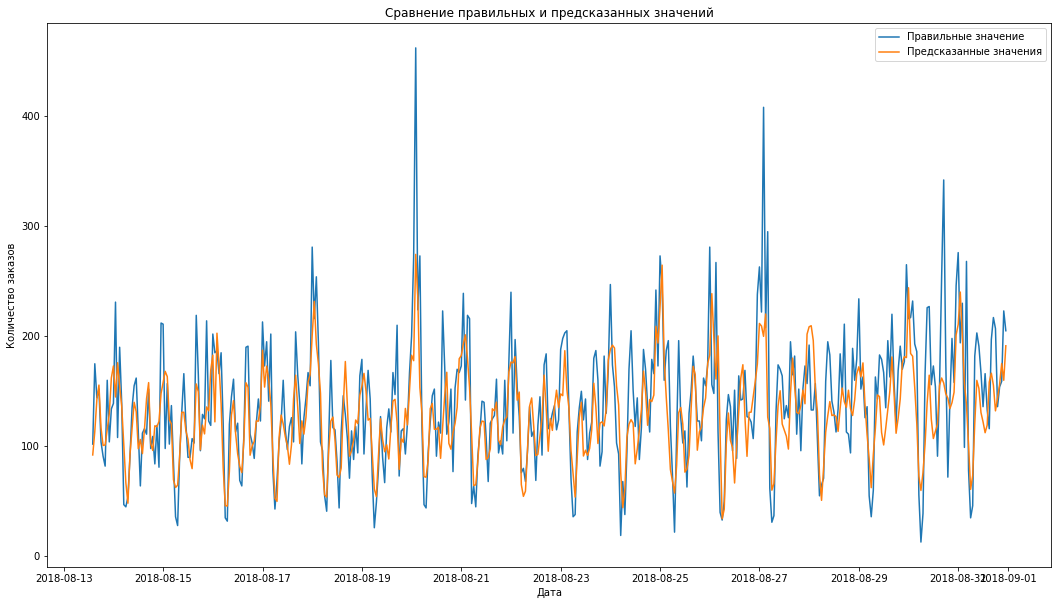

In [27]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(test['num_orders'], label='Правильные значение')
ax.plot(predict, label='Предсказанные значения')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.set_title('Сравнение правильных и предсказанных значений')
ax.legend()
plt.show()

## Вывод

Передо мной стояла задача временных рядов, необходимо было предсказать количество вызовов такси на основе уже имеющихся данных.\
Для начала был произведён анализ: Количество заказов возрастает в течение рассматриваемого периода, выходит на свой пик в сентябре. По вечерам - пик нагрузки, ночью - она минимальна. В четверг нагрузка на пике, в воскресенье-понедельник нагрузка на такси уменьшается. \
Далее были обучены две модели: Линейная Регрессия и модель с бустингом: CatBoostRegressor. У обоих моделей значение метрик в рамках допустимых (меньше 48), но лучше справилась модель с бустингом, значение метрики у ней на 3 лучше. После было проведено тестирование модели на тестовых данных: модель справилась успешно